# (실습) 케라스와 텐서플로우

## 텐서 관련

**문제 1**

[텐서 소개(Introduction to Tensors)](https://www.tensorflow.org/guide/tensor)를 정리하라.

## 케라스 관련

[TensorFlow Playground](https://playground.tensorflow.org)에서 분류와 회귀 모델의 학습과정을 살펴 보면서 
문제를 해결하는 최선의 모델을 찾고자 한다.
그런 다음에 아래 요소들에 적절한 값이 선택된 이유를 (추정해서) 설명할 수 있어야 한다.

- 특성(features) 선택
- 학습률(learning rate)
- 활성화 함수(activation function)
- 규제(regularization)와 규제율(regularization rate)
- 배치 크기(batch size)
- 은닉층(hidden layer)과 유닛(unit 또는 neuron) 수

**문제 1**

아래 그림은 음성 데이터(주황색)와 양성 데이터(파랑색)를 분류하는 목적으로 훈련 시키려 하는 심층 신경망 모델을 보여준다.

- 입력 특성: $x_1$, $x_2$
- 은닉층(hidden layer) 2개
    - 첫째 은닉층: 유닛 4개
    - 둘째 은닉층: 유닛 2개
    
유닛과 유닛을 연결하는 파란선/주황선은 각각 음의 가중치와 양의 가중치 값을 가리킨다.
선의 두께는 가중치의 절댓값에 해당한다.
즉, 두꺼운 선일 수록 해당 가중치의 절댓값이 커서 결국 입력 유닛에 저장된 값이 출력 유닛에 저장되는 값을 계산할 때 기여도가 보다 크다.


<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a07.jpg" style="width:700px;"></div>


위 사진의 모델을 훈련시키면 다음과 같이 결과가 나온다.

- 훈련 에포크: 505
- 학습률: 0.03
- 층에 사용되는 활성화 함수: Tanh
- 평가 지표
    - 테스트셋에 대한 손실값: 0.003
    - 훈련셋에 대한 손실값: 0.001



<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a05.png" style="width:700px;"></div>


반면에 하나의 은닉층만 사용하면 결과가 다르게 나온다.

- 훈련 에포크: 511
- 학습률: 0.03
- 층에 사용되는 활성화 함수: Tanh
- 평가 지표
    - 테스트셋에 대한 손실값: 0.016
    - 훈련셋에 대한 손실값: 0.004

즉, 훈련된 모델의 성능(평가지표)가 두 개의 은닉층을 사용하는 모델보다 나쁘다.
특히 테스트셋에 대한 성능이 훈련셋에 대한 성능보다 많이 떨어져서
과대적합(overfitting)이 보다 심하게 발생했다.


<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a04.png" style="width:700px;"></div>


은닉층을 아래 그림에서처럼 세 개로 늘리면 성능이 두 개의 은닉층을 사용할 때보다 성능이 좀 더 좋아진다.

- 훈련 에포크: 234
- 학습률: 0.03
- 층에 사용되는 활성화 함수: Tanh
- 평가 지표
    - 테스트셋에 대한 손실값: 0.001
    - 훈련셋에 대한 손실값: 0.001

에포크가 234로 이전보다 훨씬 빠르게 좋은 분류 모델을 학습시킨다. 
은닉층을 늘린다고 무조건 좋아지는 것은 일반적으로 아니지만 이 경우엔 최선의 결과를 낳았다.


<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a06.png" style="width:700px;"></div>


In [3]:
import tensorflow as tf
import numpy as np
import sklearn
import matplotlib.pyplot as plt

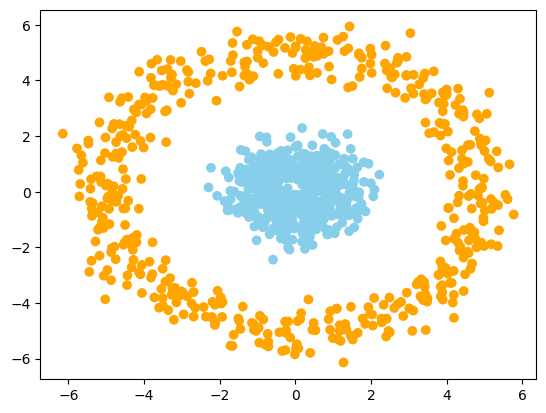

In [6]:
from sklearn.datasets import make_circles
X, y = make_circles(1000, noise=0.1, factor=0.2)

plt.scatter(X[:,0]*5, X[:,1]*5, c=['orange' if i==0 else 'skyblue' for i in y])
plt.show()

In [5]:
type(X)

numpy.ndarray

## 텐서플로우 관련

아래 코드는 순수 텐서플로우를 이용하여 이진분류 문제를 해결하는 코드이다.

In [ ]:
import numpy as np
import tensorflow as tf

# 데이터셋 크기
num_samples_per_class = 1000

# 음성 데이터셋
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

# 양성 데이터셋
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

# 입력 및 타깃 데이터셋
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

# 가중치와 편향        
input_dim = 2     # 입력 샘플의 특성이 2개
output_dim = 1    # 하나의 값으로 출력

# 가중치: 무작위 초기화
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))

# 편향: 0으로 초기화
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

# 모델 지정(하나의 층 사용)
def model(inputs):
    return tf.matmul(inputs, W) + b

# 손실함수
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

# 학습률
learning_rate = 0.1

# 훈련 스텝
def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

# 모델 학습
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.9927
Loss at step 1: 0.1929
Loss at step 2: 0.1130
Loss at step 3: 0.0973
Loss at step 4: 0.0898
Loss at step 5: 0.0839
Loss at step 6: 0.0787
Loss at step 7: 0.0739
Loss at step 8: 0.0695
Loss at step 9: 0.0655
Loss at step 10: 0.0619
Loss at step 11: 0.0586
Loss at step 12: 0.0556
Loss at step 13: 0.0529
Loss at step 14: 0.0504
Loss at step 15: 0.0481
Loss at step 16: 0.0461
Loss at step 17: 0.0442
Loss at step 18: 0.0425
Loss at step 19: 0.0409
Loss at step 20: 0.0395
Loss at step 21: 0.0382
Loss at step 22: 0.0370
Loss at step 23: 0.0359
Loss at step 24: 0.0350
Loss at step 25: 0.0341
Loss at step 26: 0.0333
Loss at step 27: 0.0325
Loss at step 28: 0.0318
Loss at step 29: 0.0312
Loss at step 30: 0.0307
Loss at step 31: 0.0302
Loss at step 32: 0.0297
Loss at step 33: 0.0293
Loss at step 34: 0.0289
Loss at step 35: 0.0285
Loss at step 36: 0.0282
Loss at step 37: 0.0279
Loss at step 38: 0.0277
Loss at step 39: 0.0274


위 코드의 실행결과는 다음과 같이 이진분류 모델이다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/HighResolutionFigures/figure_3-8.png" style="width:500px;"></div>

<p><div style="text-align: center">&lt;그림 출처: <a href="https://www.manning.com/books/deep-learning-with-python-second-edition">Deep Learning with Python(2판)</a>&gt;</div></p>

**문제 1**

위 코드는 학습과정에서 전체 데이터셋을 하나의 배치로 사용한다.
미니배치 학습을 지원하도록 코드를 수정한 후에 훈련을 진행하여 최선의 모델을 구현하라.
배치 크기는 32로 한다.

**문제 2**

`metrics`로 예측 정확도를 훈련 과정 중에 측정하는 기능을 추가하라. 

**문제 3**

위 코드는 입력값에서 바로 출력값을 계산한다. 
순전파에서 네 개의 유닛으로 구성된 층(layer)을 통과하도록 모델을 수정한 모델을 훈련시켜서
최선의 모델을 구현하라.
단, 미니 배치와 정확도를 측정하는 기능도 함께 사용한다.

힌트: [저수준 선형 분류 신경망](https://colab.research.google.com/github/codingalzi/dlp2/blob/master/excs/exc-keras_and_tf-example.ipynb)